Introduction by Example
=======================

This short example will demonstrate how you can use WLPlan for generating features for planning problems and states which you can then use to train a regression model.

A longer example of using WLPlan for training, inference and search in Python is available in this [test file](https://github.com/DillonZChen/wlplan/blob/main/tests/test_train_eval_blocks.py). This notebook only contains the training part.

The [GOOSE](https://github.com/DillonZChen/goose) planner provides an optimised usage of WLPlan that implements training in Python, and inference and search in C++.

**NOTE** This notebook requires Python 3.10, 3.11 or 3.12. You can ensure this by creating a new conda environment such as by
```
conda create l4p-tutorial python=3.10
conda activate l4p-tutorial
```

In [ ]:
# Ensure that Python version is 3.10, 3.11 or 3.12
import sys
if sys.version_info < (3, 10) or sys.version_info >= (3, 13):
    print("This script requires Python 3.10, 3.11, or 3.12\n")
    exit(1)

## Setup

We begin by installing and importing some Python packages
- `pymdzcf`: a [mimir](https://github.com/simon-stahlberg/mimir) fork for generating state successors
- `wlplan`: for generating feature embeddings from planning data
- `matplotlib`: for simple plots
- `numpy`: for representing feature embeddings efficiently for training
- `scikit-learn`: for training regression models
- `tqdm`: for displaying progress bars

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Python packages
import os
import numpy as np
import pickle
import pymimir
from matplotlib import pyplot as plt
from tqdm import tqdm

# Useful scikit-learn functions
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.svm import LinearSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.decomposition import PCA

# Useful WLPlan imports
import wlplan
from wlplan.data import DomainDataset, ProblemDataset
from wlplan.feature_generator import init_feature_generator, get_available_feature_generators, get_available_pruning_methods, get_available_graph_generators
from wlplan.planning import State, parse_domain, parse_problem

## Parse Data
The most code intensive part of a machine learning pipeline is usually the handling of data. This is no exception for planning, as you will see that most of the code in this example is spent on parsing data. Here, we parse training data in the form of `(state, optimal_cost_to_go)` pairs using a parser of your choice. We choose to use the [mimir](https://github.com/simon-stahlberg/mimir) for generating state successors but any other method can do as long as the data is eventually represented in a `wlplan.data.DomainDataset` dataset.

In [3]:
domain_pddl = "blocksworld/domain.pddl"

wlplan_domain = parse_domain(domain_pddl)
mimir_domain = pymimir.DomainParser(str(domain_pddl)).parse()

wlplan_data = []
y = []

# Loop over problems
for f in tqdm(sorted(os.listdir("blocksworld/training_plans"))):
    problem_pddl = "blocksworld/training/" + f.replace(".plan", ".pddl")
    plan_file = "blocksworld/training_plans/" + f

    # Parse problem with mimir
    mimir_problem = pymimir.ProblemParser(str(problem_pddl)).parse(mimir_domain)
    mimir_state = mimir_problem.create_state(mimir_problem.initial)

    name_to_schema = {s.name: s for s in mimir_domain.action_schemas}
    name_to_object = {o.name: o for o in mimir_problem.objects}

    # Construct wlplan problem
    name_to_predicate = {p.name: p for p in wlplan_domain.predicates}
    positive_goals = []
    for literal in mimir_problem.goal:
        assert not literal.negated
        mimir_atom = literal.atom
        wlplan_atom = wlplan.planning.Atom(
            predicate=name_to_predicate[mimir_atom.predicate.name],
            objects=[o.name for o in mimir_atom.terms],
        )
        positive_goals.append(wlplan_atom)

    wlplan_problem = parse_problem(domain_pddl, problem_pddl)
    
    # Collect actions
    actions = []
    with open(plan_file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith(";"):
                continue
            action_name = line.strip()
            action_name = action_name.replace("(", "")
            action_name = action_name.replace(")", "")
            toks = action_name.split(" ")
            schema = toks[0]
            schema = name_to_schema[schema]
            args = toks[1:]
            args = [name_to_object[arg] for arg in args]
            action = pymimir.Action.new(mimir_problem, schema, args)
            actions.append(action)

    # Collect plan trace states
    wlplan_states = []

    def mimir_to_wlplan_state(mimir_state: pymimir.State):
        atoms = []
        for atom in mimir_state.get_atoms():
            wlplan_atom = wlplan.planning.Atom(
                predicate=name_to_predicate[atom.predicate.name],
                objects=[o.name for o in atom.terms],
            )
            atoms.append(wlplan_atom)
        return State(atoms)
    
    h_opt = len(actions)
    wlplan_states.append(mimir_to_wlplan_state(mimir_state))
    y.append(h_opt)
    for action in actions:
        h_opt -= 1
        mimir_state = action.apply(mimir_state)
        wlplan_states.append(mimir_to_wlplan_state(mimir_state))
        y.append(h_opt)

    wlplan_data.append(ProblemDataset(problem=wlplan_problem, states=wlplan_states))

# This is what we need to feed into our feature generator below
dataset = DomainDataset(domain=wlplan_domain, data=wlplan_data)

# Save the dataset for future use
with open("wlplan-blocks.pkl", "wb") as f:
    pickle.dump((wlplan_domain, dataset, y), f)

100%|██████████| 56/56 [00:05<00:00, 10.81it/s]


## Generating WL Features
The following code demonstrates in a matter of lines how to generate matrix embeddings of planning data using WLPlan. Specifically, we implement the pipeline of converting planning problems and states into graphs and embedding the resulting graphs into feature embeddings in one go.

In [5]:
feature_generator = init_feature_generator(
    feature_algorithm="wl",
    domain=wlplan_domain,
    graph_representation="ploig",
    iterations=1,
    pruning="none",
    multiset_hash=True,
)
feature_generator.collect(dataset)
X = np.array(feature_generator.embed(dataset)).astype(float)
y = np.array(y)
print(f"{X.shape=}")
print(f"{y.shape=}")

[Iteration 0]
Collecting.
[Iteration 1]
Collecting.
[complete]
X.shape=(1348, 37)
y.shape=(1348,)


Below are some additional hyperparameter options.

In [4]:
print(f"{get_available_graph_generators()=}")
print(f"{get_available_feature_generators()=}")
print(f"{get_available_pruning_methods()=}")

get_available_graph_generators()=['custom', 'aoag', 'ilg', 'nilg', 'ploig']
get_available_feature_generators()=['wl', 'kwl2', 'lwl2', 'iwl', 'niwl', 'ccwl', 'ccwl-a']
get_available_pruning_methods()=['none', 'a-m', 'i-g', 'i-m', 'i-f', 'i-mf']


## Training a Linear Regression Model

The following code demonstrates how we can now just use out of the box ML libraries such as [scikit-learn](https://scikit-learn.org) for training regression models for predicting heuristic functions.

In [6]:
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
loss = np.mean((y - y_pred) ** 2)
print(f"{loss=}")
weights = model.coef_

loss=np.float64(3.6675817084433504)


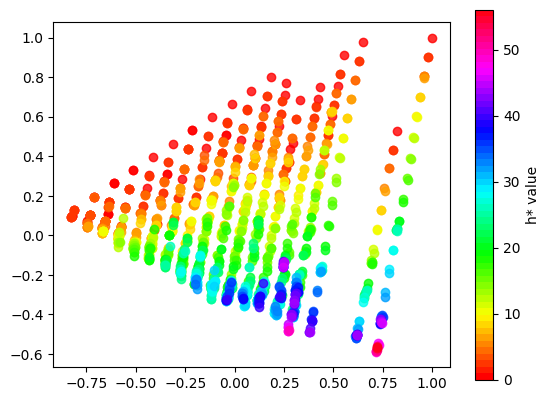

In [7]:
# PCA for visualisation
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# normalise data
X_r -= np.mean(X_r, axis=0)
X_r /= np.max(np.abs(X_r), axis=0)
max_y = int(round(max(y)))
min_y = int(round(min(y)))
y = np.array(y)

# plot
cmap = plt.get_cmap("hsv", max_y - min_y + 1)
for i in range(min_y, max_y + 1):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=cmap(i), alpha=0.8)
plt.gca().set_aspect("equal", adjustable="box")

# display colour scale
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_y, vmax=max_y))
sm.set_array([])
ax = plt.gca()
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("h* value")

plt.show()

## Saving a Learned Model

Saving a model is easy with WLPlan. We store the weights of the model and then serialise the entire feature generator to a json file.

In [8]:
feature_generator.set_weights(weights)
feature_generator.save("blocksworld.params")

**TODO** Your objective is to improve on this script and try and learn a strong model for the Blocksworld domain. This can be done in several ways, including but not limited to
- changing the hyperparameters 
- generating new data or using the data in new ways
- changing the optimisation criterion

You can evaluate your models with the script `evaluate.py` that performs heuristic search with the learned model.